In [1]:
import matplotlib.pyplot as plt


def denormalize_data(data, data_mean, data_std):
    return (data * data_std) + data_mean


def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()


def create_time_steps(length):
    return list(range(-length + 1, 1))


def show_plot(plot_data, delta, title):
    label_names = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=label_names[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=label_names[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel('Time-Step')

    return plt


class PlotData:

    def __init__(self, data_mean, data_std, model):
        self.mean = data_mean
        self.std = data_std
        self.model = model

    def plot_predictions(self, val_data, title):
        for x, y in val_data:
            plot = show_plot([denormalize_data(x[0][:, 3].numpy(), self.mean[3], self.std[3]),
                              denormalize_data(y[0].numpy(), self.mean[3], self.std[3]),
                              denormalize_data(self.model.predict(x)[0], self.mean[3],
                                               self.std[3])], 1, title)
            plot.show()


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd


In [3]:

def get_labeled_data(data, target, start_index, end_index, history_length,
                     target_length, step, single_step=False):
    feature_list = []
    label_list = []
    start_index = start_index + history_length
    if end_index is None:
        end_index = len(data) - target_length

    for i in range(start_index, end_index):
        indices = range(i - history_length, i, step)
        feature_list.append(data[indices])

        if single_step:
            label_list.append(target[i + target_length])
        else:
            label_list.append(target[i:i + target_length])

    return np.array(feature_list), np.array(label_list)


In [4]:

def normalize_dataset(data, data_mean, data_std):
    return (data - data_mean) / data_std


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000190F943F5C8>,
      dtype=object)

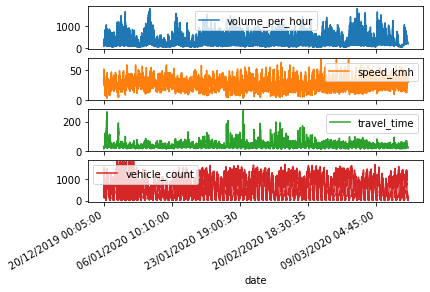

In [5]:

features_df = pd.read_csv('data.csv')
features_considered = ['volume_per_hour', 'speed_kmh', 'travel_time', 'vehicle_count']
features = features_df[features_considered]
features.index = features_df['date']
features.head()
features.plot(subplots=True)

In [6]:
TRAIN_SPLIT = 19000

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = normalize_dataset(dataset, data_mean, data_std)

tf.random.set_seed(13)
history_size = 288
target_range = 1
STEP = 1

In [7]:
x_train, y_train = get_labeled_data(dataset, dataset[:, 3], 0,
                                    TRAIN_SPLIT, history_size,
                                    target_range, STEP,
                                    single_step=True)
x_val, y_val = get_labeled_data(dataset, dataset[:, 3],
                                TRAIN_SPLIT, None, history_size,
                                target_range, STEP,
                                single_step=True)

In [8]:
print('Single window of history')
print(x_train[0])
print('\n Normalized Target to predict')
print(y_train[0])
print('validation history')
print(x_val[0])
print('\n validation Target')
print(y_val[0])

Single window of history
[[-0.83850681  0.86916496 -0.68991016 -0.10881126]
 [-0.50789999  0.86916496 -0.68991016 -0.33352099]
 [-0.25994488  0.86916496 -0.68991016 -0.16498869]
 ...
 [-0.93223555  0.72020286 -0.63217003  0.39678566]
 [-0.73796144  0.83937254 -0.67836213  0.73385026]
 [-0.60929744  0.86916496 -0.68991016  0.50914053]]

 Normalized Target to predict
0.42487437343943746
validation history
[[ 1.21500462 -1.85375591  2.48579675  0.42487437]
 [ 0.65859675 -2.01594282  3.13248616  0.34060822]
 [ 0.73784014 -1.85620899  2.48579675  0.67767283]
 ...
 [ 0.57509297 -0.87965721  0.47644038 -0.0245451 ]
 [ 1.42461616 -0.856277    0.45334433 -0.0245451 ]
 [ 1.88218282 -1.06138539  0.69585286  0.17207592]]

 validation Target
0.1720759174425279


In [9]:
BATCH_SIZE = 150
BUFFER_SIZE = 40

train_data_single = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [10]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:], return_sequences=True))
single_step_model.add(tf.keras.layers.LSTM(8))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mse')
single_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 288, 8)            416       
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 969
Trainable params: 969
Non-trainable params: 0
_________________________________________________________________


In [11]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)
    print(y.shape)

(150, 1)
(150,)


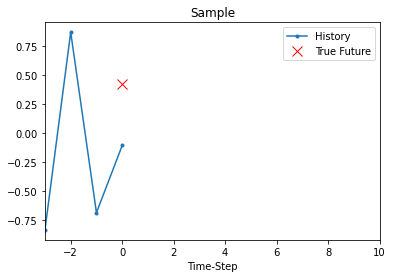

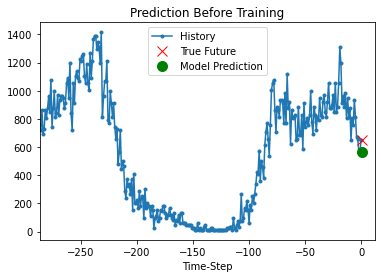

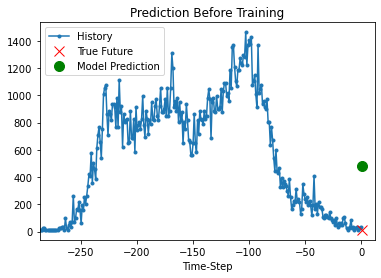

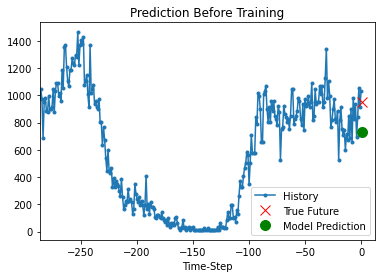

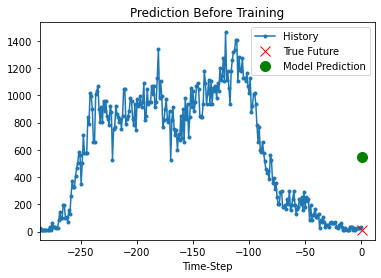

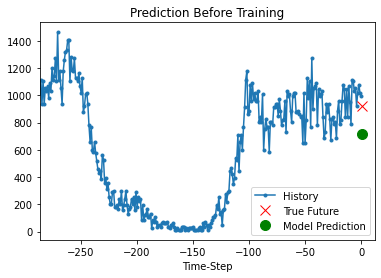

In [12]:
p = PlotData(data_mean, data_std, single_step_model)
plt = show_plot([x_train[0][0], y_train[0]], 0, 'Sample')
plt.show()
p.plot_predictions(val_data_single.take(5), 'Prediction Before Training')

In [13]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,  # x_train.shape[0],
                                            validation_data=val_data_single,
                                            validation_steps=50)  # x_val.shape[0])

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 39s 197ms/step - loss: 0.1814 - val_loss: 0.0696
Epoch 2/10
200/200 [==============================] - 41s 207ms/step - loss: 0.1396 - val_loss: 0.0880
Epoch 3/10
200/200 [==============================] - 44s 222ms/step - loss: 0.1209 - val_loss: 0.0664: 3
Epoch 4/10
200/200 [==============================] - 43s 217ms/step - loss: 0.1428 - val_loss: 0.0719
Epoch 5/10
200/200 [==============================] - 41s 203ms/step - loss: 0.1095 - val_loss: 0.0647
Epoch 6/10
200/200 [==============================] - 43s 214ms/step - loss: 0.1409 - val_loss: 0.0713
Epoch 7/10
200/200 [==============================] - 41s 204ms/step - loss: 0.1310 - val_loss: 0.0802
Epoch 8/10
200/200 [==============================] - 45s 226ms/step - loss: 0.1148 - val_loss: 0.0651
Epoch 9/10
200/200 [==============================] - 65s 324ms/step - loss: 0.1356 - val_loss: 0.0793
Epoch 10/10
200/200 [======

In [14]:
single_step_model.save("model_trained.h5")
for test_x, test_y in val_data_single.take(5):
    loss_and_metrics = single_step_model.evaluate(test_x, test_y, batch_size=BATCH_SIZE)
    print(loss_and_metrics)

150/150 [==============================] - 1s 7ms/sample - loss: 0.0494
0.04935707896947861
150/150 [==============================] - 0s 533us/sample - loss: 0.0809
0.08089817315340042
150/150 [==============================] - 0s 540us/sample - loss: 0.0478
0.04784008115530014
150/150 [==============================] - 0s 567us/sample - loss: 0.0782
0.07820412516593933
150/150 [==============================] - 0s 524us/sample - loss: 0.0432
0.04323097690939903


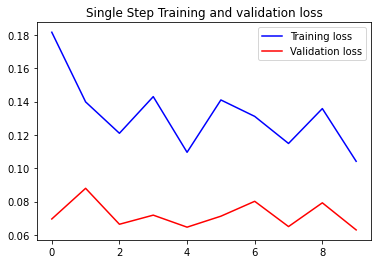

In [15]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')



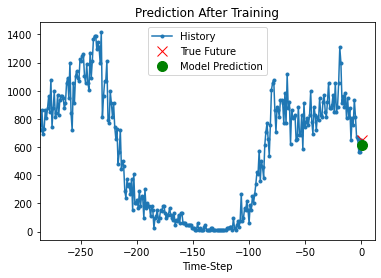

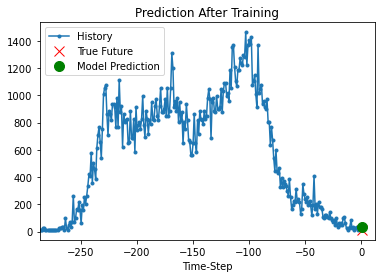

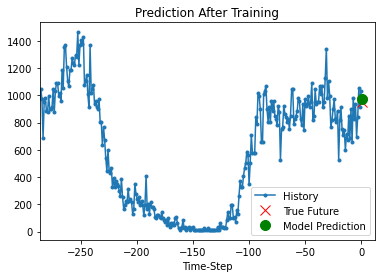

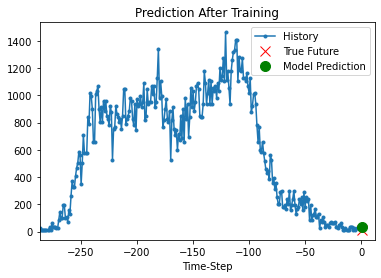

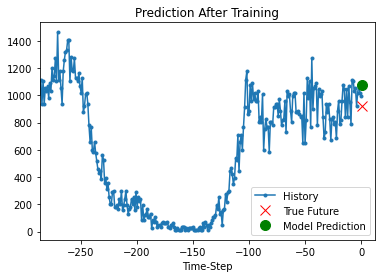

In [16]:
p.plot_predictions(val_data_single.take(5), 'Prediction After Training')